In [82]:
from PIL import Image
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K
from keras.models import Model
import pandas as pd
import numpy as np
import glob
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Image Similarity model
This notebook creates a class called ImageSimilarity that reads in the data, builds, compiles, and trains the autoencoder model, and evaluates which k images within the training set is most similar to a given input image. The class can also plot up training metrics. 

In [51]:
class ImageSimilarity():

    def __init__(self, k=25):
        self.k = k
        print('instance created')

        
    def input_training_data(self, files):
        # inputing a list of filenames, read them in and save the images
        self.files = files
        npics = len(files)
        all_imgs = np.zeros((len(files), 128, 128, 3))
        for i, ifile in enumerate(files):
            image = load_img(ifile, target_size=(128, 128))
            image = img_to_array(image)
            all_imgs[i, :, :, :] = image
        all_imgs = all_imgs.astype('float32') / 255.
        self.all_imgs = all_imgs
        
        
    def build_model(self):
        # building and compiling the autoencoder model
        input_img = Input(shape=(128, 128, 3))  # input image size

        x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (6, 6), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (2, 2), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        # encoded 128-dimensional

        x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        self.autoencoder = Model(input_img, decoded)
        self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    
    def train_model(self, epochs=20, batch_size=128):
        # train the autoencodere and get the encoded vectors of the training images
        self.epochs = epochs
        self.batch_size = batch_size
        h = self.autoencoder.fit(self.all_imgs, self.all_imgs,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_split=0.20,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
        self.h = h
        print('done with training, getting encoder')
        inp = self.autoencoder.input                                           # input placeholder
        outputs = [layer.output for layer in self.autoencoder.layers]          # all layer outputs
        self.functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]    # evaluation functions

        # Get output for all layers for all images
        layer_outs = [func([self.all_imgs, 1.]) for func in self.functors]
        all_encoded = layer_outs[8][0]
        
        vec_list = []
        for i in range(len(self.all_imgs)):
            vector = all_encoded[i, :, :, :].flatten()
            vec_list.append(vector)
        self.vec_list = vec_list
        

    def query_image_from_file(self, filename):
        # input the image to find k most similar images
        '''im = Image.open(filename)
        im_input = np.array(im) / 255.0
        im_input.resize((1, 128, 128, 3))'''
        image = load_img(filename, target_size=(128, 128))
        im_input = img_to_array(image)
        im_input.resize((1, 128, 128, 3))
        im_input = im_input.astype('float32') / 255.
        layer_outs = [func([im_input, 1.]) for func in self.functors]
        encoded = layer_outs[8][0]
        self.vec_input = encoded.flatten()
        
        
    def find_k_neighbors(self, knew = None):
        # find the k most similar images and save it to dataframe with file names
        diffs = []
        for ivec in self.vec_list:
            vec_diff = np.mean(np.abs(self.vec_input - ivec))
            diffs.append(vec_diff)

        df = pd.DataFrame({'file': files, 'vec_diff': diffs})
        self.df = df
        
        self.k = knew if knew is not None else self.k
        self.dfhead = df.sort_values(by='vec_diff').head(self.k)
        return self.dfhead

    
    def display_results(self):
        # Loop over results display the images
        for ifile in self.dfhead['file']:
            im = Image.open(ifile)
            display(im.resize((28 * 8, 28 * 8)))
            
            
    def plot_history(self, metric, color='orange'):
        # Loss plots as a function of epochs
        plt.figure(figsize=(8, 8))

        SMALL_SIZE = 8 * 2
        MEDIUM_SIZE = 10 * 2
        BIGGER_SIZE = 12 * 2

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

        plt_y = self.h.history.get(metric)
        plt_x = list(range(1, len(plt_y) + 1))
        
        plt.plot(plt_x, plt_y, linewidth=10, c='k')
        plt.plot(plt_x, plt_y, linewidth=5, c=color)

        plt.ylabel(metric)
        plt.xlabel('epoch')

        plt.title(metric + ' during training')
        plt.show()
        
        
    def plot_tsne(self, lr=30):
        # Reduce the dimensions further with T-SNE and plot the results
        
        plant_dict = {'succulents': 'green', 'nonsucculents': 'pink'}
        self.df['plant_type'] = self.df['file'].map(lambda x: x.split('/')[2])
        self.df['color'] = self.df['plant_type'].map(lambda x: plant_dict[x])
    
        new_mat = np.array(self.vec_list)
        tsne = TSNE(n_components=2,learning_rate=lr, init = 'random',  random_state=419)
        x_tsne = tsne.fit_transform(new_mat)

        x_svd = x_tsne
        plt.figure(figsize=(16,16))
        plt.scatter(x_svd[:, 0], x_svd[:, 1], c = list(self.df['color']))
        
        plt.title('T-SNE 2-D representation of encoded images')
        plt.show()
        
        
    def calc_score(self, n_iter=1000):
        # Find the score. 1000 iterations to find how many output images
        # equal the same geotype as the randomly selected input image
        # the average score of the 1000 intrations is outputted
        all_scores = 0.0
        for i in range(n_iter):
            irand = np.random.choice(len(self.vec_list))
            vec_random = self.vec_list[irand]

            diffs = []
            for ivec in self.vec_list:
                vec_diff = np.sum(np.abs(vec_random - ivec))
                diffs.append(vec_diff)

            k= 25
            df = pd.DataFrame({'file': self.files, 'vec_diff': diffs})
            df['geotype'] = df['file'].map(lambda x: x.split('/')[2])
            
            dfhead = df.sort_values(by='vec_diff').head(k)
            score = sum(dfhead['geotype'] == dfhead['geotype'].iloc[0])
            all_scores += score
        avg_score = all_scores/ 1000.0
        self.avg_score = avg_score
        return avg_score

In [52]:
files = glob.glob('../training/*/*')
new_model = ImageSimilarity(k=4)
new_model.input_training_data(files)
new_model.build_model()
new_model.train_model(epochs=150)

instance created
Train on 472 samples, validate on 119 samples
Epoch 1/150
472/472 [==============================] - 13s 28ms/step - loss: 0.6927 - val_loss: 0.6923
Epoch 2/150
472/472 [==============================] - 14s 31ms/step - loss: 0.6900 - val_loss: 0.6900
Epoch 3/150
472/472 [==============================] - 12s 25ms/step - loss: 0.6833 - val_loss: 0.6977
Epoch 4/150
472/472 [==============================] - 12s 25ms/step - loss: 0.6799 - val_loss: 0.6928
Epoch 5/150
472/472 [==============================] - 12s 25ms/step - loss: 0.6776 - val_loss: 0.6904
Epoch 6/150
472/472 [==============================] - 12s 25ms/step - loss: 0.6763 - val_loss: 0.6934
Epoch 7/150
472/472 [==============================] - 12s 25ms/step - loss: 0.6750 - val_loss: 0.6924
Epoch 8/150
472/472 [==============================] - 14s 30ms/step - loss: 0.6737 - val_loss: 0.6898
Epoch 9/150
472/472 [==============================] - 14s 29ms/step - loss: 0.6724 - val_loss: 0.6906
Epoch 10/1

472/472 [==============================] - 12s 26ms/step - loss: 0.6112 - val_loss: 0.6108
Epoch 80/150
472/472 [==============================] - 12s 26ms/step - loss: 0.6109 - val_loss: 0.6114
Epoch 81/150
472/472 [==============================] - 12s 26ms/step - loss: 0.6111 - val_loss: 0.6106
Epoch 82/150
472/472 [==============================] - 15s 31ms/step - loss: 0.6106 - val_loss: 0.6104
Epoch 83/150
472/472 [==============================] - 15s 32ms/step - loss: 0.6106 - val_loss: 0.6108
Epoch 84/150
472/472 [==============================] - 12s 26ms/step - loss: 0.6106 - val_loss: 0.6104
Epoch 85/150
472/472 [==============================] - 15s 31ms/step - loss: 0.6104 - val_loss: 0.6104
Epoch 86/150
472/472 [==============================] - 15s 31ms/step - loss: 0.6104 - val_loss: 0.6105
Epoch 87/150
472/472 [==============================] - 14s 30ms/step - loss: 0.6106 - val_loss: 0.6106
Epoch 88/150
472/472 [==============================] - 13s 27ms/step - loss:

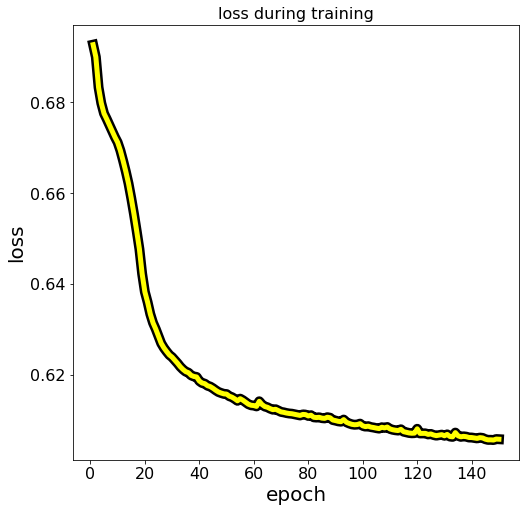

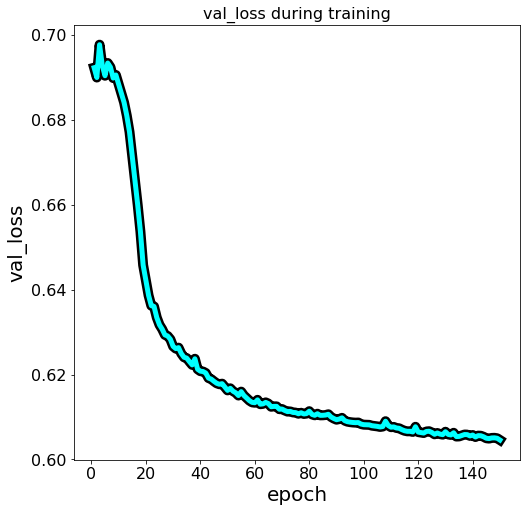

In [53]:
new_model.plot_history('loss', 'yellow')
new_model.plot_history('val_loss', 'cyan')

### Example

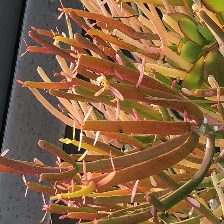

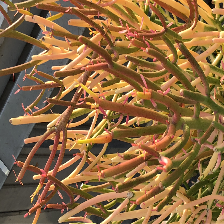

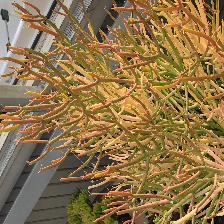

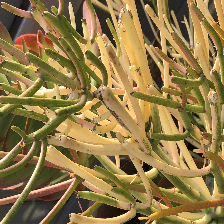

In [74]:
new_model.query_image_from_file('../training/succulents/IMG_0594.jpg')
new_model.find_k_neighbors()
new_model.display_results()

In [56]:
new_model.dfhead

,file,vec_diff
376,../training/succulents/IMG_0505.jpg,0.000000
428,../training/succulents/IMG_0594.jpg,0.128158
424,../training/succulents/IMG_0590.jpg,0.134660
462,../training/succulents/IMG_1032.jpg,0.137915
